In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import yaml
from calculate_descriptives import (
    calculate_activity_per_cell,
    calculate_number_of_unique_users_per_cell,
)
from common import plot_heatmap, to_matrix, transform
from matplotlib.colors import ListedColormap

with open("../plotting_config.yaml", "r") as fp:
    config = yaml.safe_load(fp)

ox.settings.use_cache = True
ox.settings.log_console = False

In [2]:
data = pd.read_csv(
    "../data/yjmob100k/yjmob100k-dataset1.csv",
    engine="pyarrow",
)
data.head(5)

,uid,d,t,x,y
0,0,0,1,79,86
1,0,0,2,79,86
2,0,0,8,77,86
3,0,0,9,77,86
4,0,0,19,81,89


In [3]:
try:
    activity = pd.read_csv("../output/activity.csv")
except FileNotFoundError:
    activity = calculate_activity_per_cell(data)
    activity.to_csv("../output/activity.csv", index=False)

activity["count_log"] = activity["count"].apply(np.log10).fillna(0)

In [4]:
try:
    unique_users = pd.read_csv("../output/unique_users.csv")
except FileNotFoundError:
    unique_users = calculate_number_of_unique_users_per_cell(data)
    unique_users.to_csv("../output/unique_users.csv", index=False)

unique_users["count_log"] = unique_users["count"].apply(np.log10).fillna(0)

In [5]:
activity_raster = to_matrix(activity, value="count")
user_raster = to_matrix(unique_users, value="count")

activity_raster_fixed = transform(activity_raster)
user_raster_fixed = transform(user_raster)

In [6]:
grid = gpd.read_file("../output/grid_bl_2449.geojson", engine="pyogrio")

grid_c = grid.copy()
grid_c["geometry"] = grid.centroid
grid_c.to_crs(4326, inplace=True)
grid["radius"] = grid.centroid
grid["radius"] = grid["radius"].buffer(500)

<Axes: >

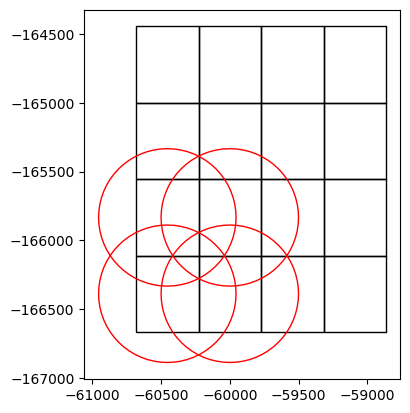

In [7]:
fig, ax = plt.subplots()
grid.query("x<5 & y<5").plot(ec="k", fc="none", ax=ax)
grid.set_geometry("radius").query("x<3 & y<3").plot(ec="r", fc="none", ax=ax)

<Axes: >

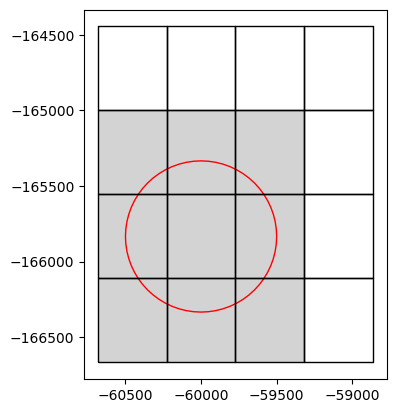

In [8]:
fig, ax = plt.subplots()
grid.query("x<5 & y<5").plot(ec="k", fc="none", ax=ax, zorder=5)
grid[grid["geometry"].intersects(grid.query("x==2 & y==2")["radius"].tolist()[0])].plot(
    ec="none", fc="lightgrey", ax=ax, zorder=1
)
grid.set_geometry("radius").query("x==2 & y==2").plot(ec="r", fc="none", ax=ax)

In [ ]:
# for x in range(1, 201, 2):
#     for y in range(1, 201, 2):
#         grid[
#             grid["geometry"].intersects(
#                 grid.query(f"x=={x} & y=={y}")["radius"].tolist()[0]
#             )
#         ]["activity_count"].sum()

In [ ]:
k = 2
records = []
for idx, x in enumerate(range(0, 200, k)):
    for idy, y in enumerate(range(0, 200, k)):
        v = [
            activity_raster_fixed[x][y],
            activity_raster_fixed[x + 1][y],
            activity_raster_fixed[x + 1][y + 1],
            activity_raster_fixed[x][y + 1],
        ]
        records.append([idx, idy, np.sum(v)])

In [ ]:
pd.DataFrame.from_records(records, columns=["x", "x", "activity_count"])

In [9]:
def merge_cells(k: int = 2) -> pd.DataFrame:
    records = []
    for idx, x in enumerate(range(0, 200, k)):
        for idy, y in enumerate(range(0, 200, k)):
            v = []
            for i in range(k):
                for j in range(k):
                    v.append(activity_raster_fixed[x + i][y + j])
            records.append([idx, idy, np.sum(v)])
    return pd.DataFrame.from_records(records, columns=["x", "y", "activity_count"])

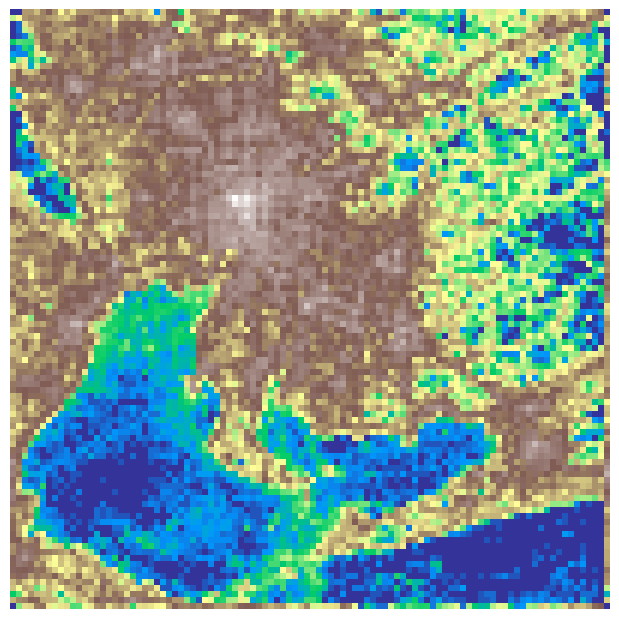

In [21]:
rescaled_2_df = merge_cells(2)
rescaled_2_df["binary"] = rescaled_2_df["activity_count"].apply(
    lambda x: 0 if x < 75 else 1
)
rescaled_2_df["activity_count_log"] = (
    rescaled_2_df["activity_count"]
    .apply(np.log10)
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)
rescaled_2 = to_matrix(rescaled_2_df, (100, 100), "activity_count_log")
f2, _ = plot_heatmap(rescaled_2, figsize=(6, 6), cmap="terrain")
f2.savefig(
    "../figures/rescaled/rescaled_2.png",
    dpi=300,
    metadata=config["metadata"],
)
rescaled_2_df.to_csv("../output/rescale/rescaled_2.csv", index=False)

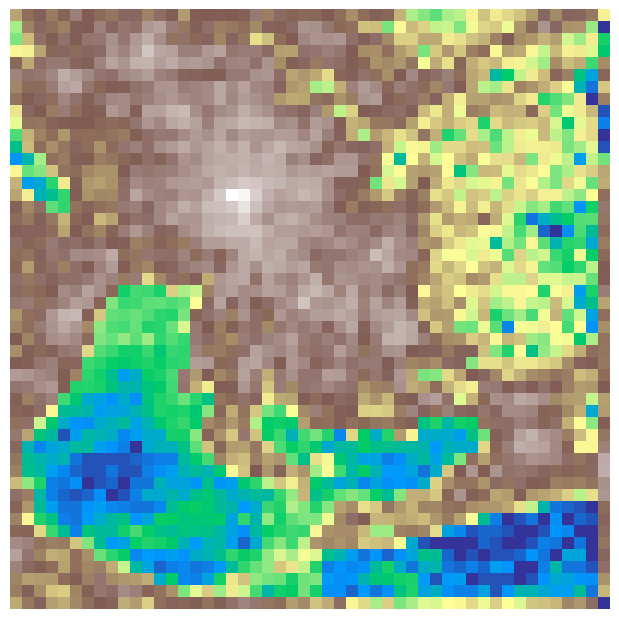

In [23]:
rescaled_4_df = merge_cells(4)
rescaled_4_df["binary"] = rescaled_4_df["activity_count"].apply(
    lambda x: 0 if x < 75 else 1
)
rescaled_4_df["activity_count_log"] = (
    rescaled_4_df["activity_count"]
    .apply(np.log10)
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)
rescaled_4 = to_matrix(rescaled_4_df, (50, 50), "activity_count_log")
f4, _ = plot_heatmap(rescaled_4, figsize=(6, 6), cmap="terrain")
f4.savefig(
    "../figures/rescaled/rescaled_4.png",
    dpi=300,
    metadata=config["metadata"],
)
rescaled_4_df.to_csv("../output/rescale/rescaled_4.csv", index=False)

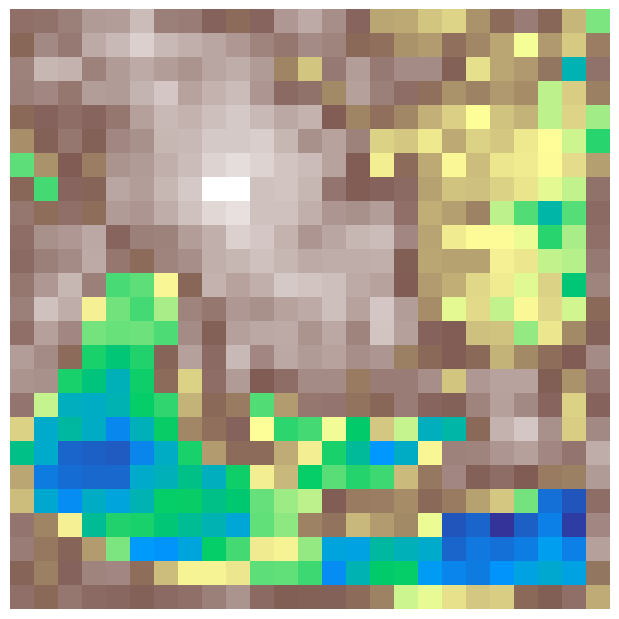

In [24]:
rescaled_8_df = merge_cells(8)
rescaled_8_df["binary"] = rescaled_8_df["activity_count"].apply(
    lambda x: 0 if x < 75 else 1
)
rescaled_8_df["activity_count_log"] = (
    rescaled_8_df["activity_count"]
    .apply(np.log10)
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)
rescaled_8 = to_matrix(rescaled_8_df, (25, 25), "activity_count_log")
f8, _ = plot_heatmap(rescaled_8, figsize=(6, 6), cmap="terrain")
f8.savefig("../figures/rescaled/rescaled_8.png", dpi=300, metadata=config["metadata"])
rescaled_8_df.to_csv("../output/rescale/rescaled_8.csv", index=False)

## Create binary images for template matching

In [ ]:
mx = to_matrix(rescaled_2_df, (100, 100), value="binary")
f_b, _ = plot_heatmap(mx, figsize=(100, 100), dpi=1, cmap="binary")
f_b.savefig(
    "../figures/rescaled/activity_binary_1000_1000.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)
f_b, _ = plot_heatmap(
    mx, figsize=(100, 100), dpi=1, cmap=ListedColormap(["white", "blue"])
)
f_b.savefig(
    "../figures/rescaled/activity_binary_1000_1000_blue.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)
f_b, _ = plot_heatmap(mx, figsize=(1, 1), dpi=100, cmap="binary")
f_b.savefig(
    "../figures/rescaled/activity_binary_1000_1000_dpi_fixed.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

In [ ]:
rx, ry = 1000, 1000
sx, sy = 100000 // rx, 100000 // ry
mx = to_matrix(rescaled_2_df, (sx, sy), value="binary")
f_b, _ = plot_heatmap(mx, figsize=(sx, sy), dpi=1, cmap="binary")
f_b.savefig(
    f"../figures/rescaled/activity_binary_{rx}_{ry}.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)
f_b, _ = plot_heatmap(
    mx, figsize=(sx, sy), dpi=1, cmap=ListedColormap(["white", "blue"])
)
f_b.savefig(
    f"../figures/rescaled/activity_binary_{rx}_{ry}_blue.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

In [ ]:
rx, ry = 2000, 2000
sx, sy = 100000 // rx, 100000 // ry
mx = to_matrix(rescaled_4_df, (sx, sy), value="binary")
f_b, _ = plot_heatmap(mx, figsize=(sx, sy), dpi=1, cmap="binary")
f_b.savefig(
    f"../figures/rescaled/activity_binary_{rx}_{ry}.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)
f_b, _ = plot_heatmap(
    mx, figsize=(sx, sy), dpi=1, cmap=ListedColormap(["white", "blue"])
)
f_b.savefig(
    f"../figures/rescaled/activity_binary_{rx}_{ry}_blue.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

In [ ]:
rx, ry = 4000, 4000
sx, sy = 100000 // rx, 100000 // ry
mx = to_matrix(rescaled_8_df, (sx, sy), value="binary")
f_b, _ = plot_heatmap(mx, figsize=(sx, sy), dpi=1, cmap="binary")
f_b.savefig(
    f"../figures/rescaled/activity_binary_{rx}_{ry}.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)
f_b, _ = plot_heatmap(
    mx, figsize=(sx, sy), dpi=1, cmap=ListedColormap(["white", "blue"])
)
f_b.savefig(
    f"../figures/rescaled/activity_binary_{rx}_{ry}_blue.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)

In [27]:
rescaled_8_df["binary"] = rescaled_8_df["activity_count"].apply(
    lambda x: 0 if x < 375 else 1
)
rx, ry = 4000, 4000
sx, sy = 100000 // rx, 100000 // ry
mx = to_matrix(rescaled_8_df, (sx, sy), value="binary")
f_b, _ = plot_heatmap(mx, figsize=(sx, sy), dpi=1, cmap="binary")
f_b.savefig(
    f"../figures/rescaled/activity_binary_{rx}_{ry}_v2.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)
f_b, _ = plot_heatmap(
    mx, figsize=(sx, sy), dpi=1, cmap=ListedColormap(["white", "blue"])
)
f_b.savefig(
    f"../figures/rescaled/activity_binary_{rx}_{ry}_v2_blue.png",
    facecolor="white",
    pad_inches=0,
    metadata=config["metadata"],
)